In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import binarize
from sklearn.model_selection import cross_val_score

In [4]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Evaluating a classification model ([video #9](https://www.youtube.com/watch?v=85dtiMz9tSo&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&index=9))

Created by [Data School](http://www.dataschool.io/). Watch all 9 videos on [YouTube](https://www.youtube.com/playlist?list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A). Download the notebooks from [GitHub](https://github.com/justmarkham/scikit-learn-videos).

**Note:** This notebook uses Python 3.6 and scikit-learn 0.19.1. The original notebook (shown in the video) used Python 2.7 and scikit-learn 0.16, and can be downloaded from the [archive branch](https://github.com/justmarkham/scikit-learn-videos/tree/archive).

## Agenda

- What is the purpose of **model evaluation**, and what are some common evaluation procedures?
- What is the usage of **classification accuracy**, and what are its limitations?
- How does a **confusion matrix** describe the performance of a classifier?
- What **metrics** can be computed from a confusion matrix?
- How can you adjust classifier performance by **changing the classification threshold**?
- What is the purpose of an **ROC curve**?
- How does **Area Under the Curve (AUC)** differ from classification accuracy?

## Review of model evaluation

- Need a way to choose between models: different model types, tuning parameters, and features
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requires a **model evaluation metric** to quantify the model performance

### Model evaluation procedures

1. **Training and testing on the same data**
    - Rewards overly complex models that "overfit" the training data and won't necessarily generalize
2. **Train/test split**
    - Split the dataset into two pieces, so that the model can be trained and tested on different data
    - Better estimate of out-of-sample performance, but still a "high variance" estimate
    - Useful due to its speed, simplicity, and flexibility
3. **K-fold cross-validation**
    - Systematically create "K" train/test splits and average the results together
    - Even better estimate of out-of-sample performance
    - Runs "K" times slower than train/test split

### Model evaluation metrics

- **Regression problems:** Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
- **Classification problems:** Classification accuracy

## Classification accuracy

[Pima Indians Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) originally from the UCI Machine Learning Repository

In [5]:
# read the data into a pandas DataFrame
#import pandas as pd
path = 'data/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(path, header=None, names=col_names)

In [6]:
# print the first 5 rows of data
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Question:** Can we predict the diabetes status of a patient given their health measurements?

In [7]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

In [8]:
# split X and y into training and testing sets
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
# train a logistic regression model on the training set
#from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [10]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [11]:
# calculate accuracy
#from sklearn import metrics
# video has slightly different model result: 0.6927
print(metrics.accuracy_score(y_test, y_pred_class))

0.6770833333333334


**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [12]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

In [13]:
# calculate the percentage of ones
y_test.mean()

0.3229166666666667

In [14]:
# calculate the percentage of zeros
1 - y_test.mean()

0.6770833333333333

In [15]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.6770833333333333

In [16]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
Name: label, dtype: float64

Comparing the **true** and **predicted** response values

In [17]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
- And, it does not tell you what **"types" of errors** your classifier is making

## Confusion matrix

Table that describes the performance of a classification model

In [18]:
# IMPORTANT: first argument is true values, second argument is predicted values
# video has slightly different model results--values shown in graphic below
print(metrics.confusion_matrix(y_test, y_pred_class))

[[114  16]
 [ 46  16]]


![Small confusion matrix](images/09_confusion_matrix_1.png)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes (15)
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes (118)
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error") (12)
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error") (47)

In [19]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [48]:
TP, TN, FP, FN

(16, 114, 16, 46)

![Large confusion matrix](images/09_confusion_matrix_2.png)

## Metrics computed from a confusion matrix

**Classification Accuracy:** Overall, how often is the classifier correct?

In [21]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.6770833333333334
0.6770833333333334


**Classification Error:** Overall, how often is the classifier incorrect?

- Also known as "Misclassification Rate"

In [22]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.3229166666666667
0.32291666666666663


**Sensitivity:** When the actual value is positive, how often is the prediction correct?

- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"

In [23]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.25806451612903225
0.25806451612903225


**Specificity:** When the actual value is negative, how often is the prediction correct?

- How "specific" (or "selective") is the classifier in predicting positive instances?

In [24]:
print(TN / float(TN + FP))

0.8769230769230769


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [25]:
print(FP / float(TN + FP))

0.12307692307692308


**Precision:** When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

In [26]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.5
0.5


Many other metrics can be computed: F1 score, Matthews correlation coefficient, etc.

**Conclusion:**

- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**
- **Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- **Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

## Adjusting the classification threshold

In [27]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [28]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10, :]

array([[0.61405867, 0.38594133],
       [0.7505398 , 0.2494602 ],
       [0.74167648, 0.25832352],
       [0.60291327, 0.39708673],
       [0.88426611, 0.11573389],
       [0.87695895, 0.12304105],
       [0.50819992, 0.49180008],
       [0.44582289, 0.55417711],
       [0.77950769, 0.22049231],
       [0.25853303, 0.74146697]])

In [29]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([0.38594133, 0.2494602 , 0.25832352, 0.39708673, 0.11573389,
       0.12304105, 0.49180008, 0.55417711, 0.22049231, 0.74146697])

In [30]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [31]:
# allow plots to appear in the notebook
#%matplotlib inline
#import matplotlib.pyplot as plt

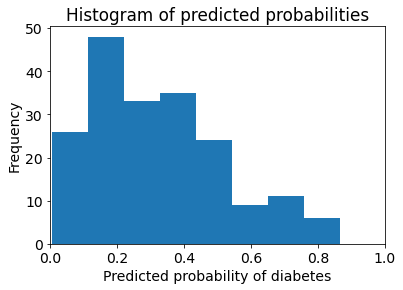

In [32]:
# histogram of predicted probabilities
plt.rcParams['font.size'] = 14;
plt.hist(y_pred_prob, bins=8);
plt.xlim(0, 1);
plt.title('Histogram of predicted probabilities');
plt.xlabel('Predicted probability of diabetes');
plt.ylabel('Frequency');

**Decrease the threshold** for predicting diabetes in order to **increase the sensitivity** of the classifier

In [33]:
# predict diabetes if the predicted probability is greater than 0.3
#from sklearn.preprocessing import binarize
#y_pred_class = binarize([y_pred_prob], 0.3)[0]
y_pred_class = binarize([y_pred_prob], threshold=0.3)[0]

In [34]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([0.38594133, 0.2494602 , 0.25832352, 0.39708673, 0.11573389,
       0.12304105, 0.49180008, 0.55417711, 0.22049231, 0.74146697])

In [35]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])

In [36]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[114  16]
 [ 46  16]]


In [37]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[82 48]
 [17 45]]


In [38]:
# sensitivity has increased (used to be 0.24)
# video has slightly different model results
print(46 / float(46 + 16))

0.7419354838709677


In [39]:
# specificity has decreased (used to be 0.91)
# video has slightly different model results
print(80 / float(80 + 50))

0.6153846153846154


**Conclusion:**

- **Threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions
- Threshold can be **adjusted** to increase sensitivity or specificity
- Sensitivity and specificity have an **inverse relationship**

## ROC Curves and Area Under the Curve (AUC)

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve!

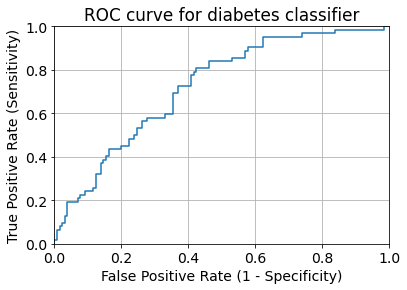

In [40]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob);
plt.plot(fpr, tpr);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.0]);
plt.title('ROC curve for diabetes classifier');
plt.xlabel('False Positive Rate (1 - Specificity)');
plt.ylabel('True Positive Rate (Sensitivity)');
plt.grid(True);

- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself

In [41]:
print(thresholds)

[1.86700739 0.86700739 0.86613122 0.7934619  0.76016373 0.75898019
 0.74269038 0.74255446 0.74146697 0.71440742 0.68627831 0.66646287
 0.59191392 0.57804433 0.56179848 0.55417711 0.54747212 0.52407024
 0.50502006 0.50177173 0.50123357 0.48600827 0.48354209 0.47202441
 0.46948157 0.46830552 0.46635231 0.46113913 0.46034603 0.44397396
 0.42720467 0.42669918 0.41883989 0.41616298 0.41191846 0.40843642
 0.40272108 0.39192458 0.38983925 0.38594133 0.37804475 0.37736515
 0.35046192 0.34886987 0.34425078 0.31875944 0.30901571 0.30423357
 0.26673856 0.25836317 0.25832352 0.25633281 0.25459599 0.25311321
 0.24255746 0.23996229 0.218916   0.21150143 0.1969813  0.19038424
 0.19011821 0.18828385 0.17958337 0.16772446 0.14589548 0.14351044
 0.11080984 0.10930907 0.05441205 0.01930679 0.00706526]


In [42]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [43]:
evaluate_threshold(0.5)

Sensitivity: 0.25806451612903225
Specificity: 0.8769230769230769


In [44]:
evaluate_threshold(0.3)

Sensitivity: 0.7258064516129032
Specificity: 0.6307692307692307


AUC is the **percentage** of the ROC plot that is **underneath the curve**:

In [45]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.7227047146401985


- AUC is useful as a **single number summary** of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy).

In [46]:
# calculate cross-validated AUC
#from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.7425071225071225

**Confusion matrix advantages:**

- Allows you to calculate a **variety of metrics**
- Useful for **multi-class problems** (more than two response classes)

**ROC/AUC advantages:**

- Does not require you to **set a classification threshold**
- Still useful when there is **high class imbalance**

## Confusion Matrix Resources

- Blog post: [Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by me
- Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes) by Rahul Patwari
- Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix (by Ed Podojil)
- Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)


## ROC and AUC Resources

- Video: [ROC Curves and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo) (14 minutes) by me, including [transcript and screenshots](http://www.dataschool.io/roc-curves-and-auc-explained/) and a [visualization](http://www.navan.name/roc/)
- Video: [ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4) (12 minutes) by Rahul Patwari
- Paper: [An introduction to ROC analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf) by Tom Fawcett
- Usage examples: [Comparing different feature sets](http://research.microsoft.com/pubs/205472/aisec10-leontjeva.pdf) for detecting fraudulent Skype users, and [comparing different classifiers](http://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets

## Other Resources

- scikit-learn documentation: [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- Guide: [Comparing model evaluation procedures and metrics](https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md) by me
- Video: [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0) (45 minutes) about how Stripe evaluates its fraud detection model, including [slides](http://www.slideshare.net/MichaelManapat/counterfactual-evaluation-of-machine-learning-models)

## Comments or Questions?

- Email: <kevin@dataschool.io>
- Website: http://dataschool.io
- Twitter: [@justmarkham](https://twitter.com/justmarkham)

In [47]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()